In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np 
from Utils import PklsFolder
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import pickle
import os
from torch.utils.data import Dataset, DataLoader

In [2]:
def dataframe_from_csv(target):
    return pd.read_csv(target,encoding='cp1252').rename(columns=lambda x: x.strip()).dropna(subset=['Flow ID'], how='all')

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

def split_ben_mal_DF(Day_DF):
    fwd_Benign_DF = Day_DF[Day_DF['Label'] == 'BENIGN'][['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']]
    bwd_Benign_DF = Day_DF[Day_DF['Label'] == 'BENIGN'][['Destination IP', 'Destination Port','Source IP', 'Source Port',  'Protocol','Label','Timestamp']]
    bwd_Benign_DF.columns = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']
    Benign_DF = pd.concat([fwd_Benign_DF, bwd_Benign_DF]).drop_duplicates(subset = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label'], keep = 'first').reset_index(drop = True)
    
    fwd_Mal_DF = Day_DF[Day_DF['Label'] != 'BENIGN'][['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']]
    bwd_Mal_DF = Day_DF[Day_DF['Label'] != 'BENIGN'][['Destination IP', 'Destination Port','Source IP', 'Source Port', 'Protocol','Label','Timestamp']]
    bwd_Mal_DF.columns = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']
    Mal_DF = pd.concat([fwd_Mal_DF,bwd_Mal_DF]).drop_duplicates(subset = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label'], keep = 'first').reset_index(drop = True)

    return Benign_DF, Mal_DF

def drop_dup_btw_df(df1, df2):
    tmp = pd.concat([df1,df2]).reset_index(drop = True)
    dup_index = tmp[tmp.duplicated(subset = ['Source IP','Source Port','Destination IP', 'Destination Port', 'Protocol'], keep = 'last')].index
    dup_index = dup_index[dup_index < len(df1)]
    return df1.drop(index = dup_index)

In [3]:
week = ['Monday','Tuesday','Wednesday','Thursday','Friday']

Benign_DF = pd.DataFrame()
Mal_DF = pd.DataFrame()

for day in week: 
    day_csv= sorted([x for x in Path('../../dataset/CICIDS2017/flow_label/TrafficLabelling').glob(f'{day}-*.csv')],reverse = True)
    day_DF_RAW = dataframe_from_csvs(day_csv)
    day_DF = day_DF_RAW.drop_duplicates(subset = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label'], keep = 'first')

    B_DF ,M_DF = split_ben_mal_DF(day_DF)
    PB_DF = drop_dup_btw_df(B_DF,M_DF)
    
    Benign_DF = pd.concat([Benign_DF,PB_DF])
    Mal_DF = pd.concat([Mal_DF, M_DF])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [2]:
pkls_dir = '../../dataset/CICIDS2017/pkls'
flow_dataset = PklsFolder(pkls_dir)

attack_class_list = ['FTP-Patator', 'SSH-Patator', 'DoS slowloris','DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed','Infiltration', 'Web Attack – Brute Force', 'Web Attack – XSS','Web Attack – Sql Injection', 'DDoS', 'PortScan', 'Bot']
attack_class = {flow : i+1 for i, flow in enumerate(attack_class_list)}

flow_cnt = flow_dataset.data_cnt_per_class()

mal_cnt = 0
for i in range(1,15):
    mal_cnt += flow_cnt[str(i)]

In [42]:
print(f'Pcap Benign flow count : {flow_cnt[str(0)]}')

Pcap Benign flow count : 2191361


In [43]:
print(f'Pcap Malicious flow count : {mal_cnt}')

Pcap Malicious flow count : 487865


In [72]:
flow_dataset.data_cnt_per_class()

{'0': 2191361,
 '1': 7982,
 '2': 5958,
 '3': 7746,
 '4': 8432,
 '5': 28216,
 '6': 14916,
 '7': 1,
 '8': 12,
 '9': 2726,
 '10': 1262,
 '11': 24,
 '12': 90784,
 '13': 317350,
 '14': 2456}

In [14]:
five_tup = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol']

In [17]:
for field in five_tup:
    benign = Benign_DF[field].value_counts().head(5).reset_index()
    benign = benign.rename(columns = {'index' : field, field : 'Count'})
    benign['Percentage'] = benign['Count'].map(lambda x : round(100 * x / Benign_DF.shape[0],2))
    
    display(benign)
    

NameError: name 'five_tup' is not defined

In [16]:
for field in five_tup:
    mal = Mal_DF[field].value_counts().head(5).reset_index()
    mal = mal.rename(columns = {'index' : field, field : 'Count'})
    mal['Percentage'] = mal['Count'].map(lambda x : round(100 * x / Mal_DF.shape[0],2))
    
    display(mal)
    

,Source IP,Count,Percentage
0,172.16.0.1,242700,49.75
1,192.168.10.50,242699,49.75
2,205.174.165.73,1232,0.25
3,192.168.10.15,360,0.07
4,192.168.10.8,263,0.05


,Source Port,Count,Percentage
0,80.0,77366,15.86
1,21.0,4233,0.87
2,22.0,3221,0.66
3,8080.0,1388,0.28
4,59328.0,999,0.20


,Destination IP,Count,Percentage
0,172.16.0.1,242700,49.75
1,192.168.10.50,242699,49.75
2,205.174.165.73,1232,0.25
3,192.168.10.15,360,0.07
4,192.168.10.8,263,0.05


,Destination Port,Count,Percentage
0,80.0,77366,15.86
1,21.0,4233,0.87
2,22.0,3221,0.66
3,8080.0,1388,0.28
4,59328.0,999,0.20


,Protocol,Count,Percentage
0,6.0,487864,100.0
1,17.0,2,0.0
2,0.0,2,0.0


In [17]:
ben_flow_len = []
mal_flow_len = []
ben_pck_len = []
mal_pck_len = []

for i in tqdm(range(len(flow_dataset))):
    flow, label = flow_dataset[i]
    
    if label == 0:
        ben_flow_len.append(len(flow))
        
        for b_idx in range(len(flow)):
            ben_pck_len.append(len(flow[b_idx]))
    elif label != 0:
        mal_flow_len.append(len(flow))
        
        for m_idx in range(len(flow)):
            mal_pck_len.append(len(flow[m_idx]))

100%|██████████| 2679226/2679226 [00:57<00:00, 46542.03it/s]


In [54]:
ben_over_200 = 0
for i in tqdm(range(len(ben_flow_len))):
    if ben_flow_len[i] > 200:
        ben_over_200 +=1

100%|██████████| 2191361/2191361 [00:00<00:00, 2357654.67it/s]


In [62]:
mal_over_200 = 0
for i in tqdm(range(len(mal_flow_len))):
    if mal_flow_len[i] > 200:
        mal_over_200 +=1

100%|██████████| 487865/487865 [00:00<00:00, 2212779.02it/s]


In [18]:
print(f'Percentage of Benign Flow Length Over 200: {100 *ben_over_200/len(ben_flow_len):.4f}%')

NameError: name 'ben_over_200' is not defined

In [63]:
print(f'Percentage of Malicious Flow Length Over 200: {100 *mal_over_200/len(mal_flow_len):.4f}%')

Percentage of Malicious Flow Length Over 200: 0.0193%


In [104]:
print(f'Average of Benign Flow Length : {pd.DataFrame(ben_flow_len).mean()}')

Average of Benign Flow Length : 0    14.656095
dtype: float64


In [105]:
print(f'Average of Malicious Flow Length : {pd.DataFrame(mal_flow_len).mean()}')

Average of Malicious Flow Length : 0    9.136474
dtype: float64


Text(0, 0.5, 'Density')

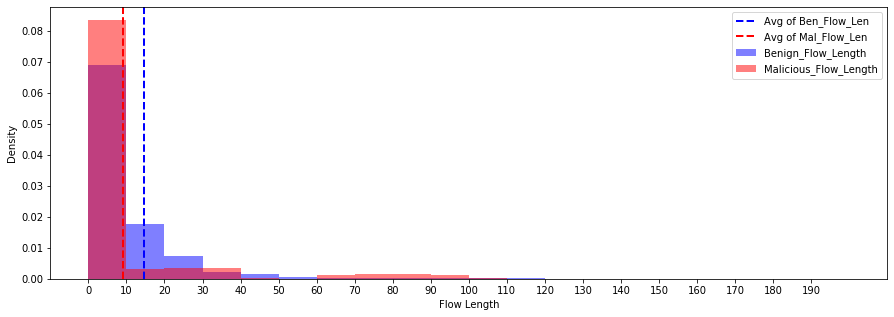

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.hist(ben_flow_len, bins = 20, alpha = 0.5, range = (0,200), density = True, color = 'b', label = 'Benign_Flow_Length')
plt.hist(mal_flow_len, bins = 20, alpha = 0.5, range = (0,200), density = True, color = 'r', label = 'Malicious_Flow_Length')
plt.xticks(np.arange(0,200,10))

plt.axvline(pd.DataFrame(ben_flow_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Flow_Len')
plt.axvline(pd.DataFrame(mal_flow_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Flow_Len')

plt.legend()
plt.xlabel('Flow Length')
plt.ylabel('Density')

In [87]:
ben_over_3000 = 0
for i in tqdm(range(len(ben_pck_len))):
    if ben_pck_len[i] > 3000:
        ben_over_3000 +=1

100%|██████████| 32116795/32116795 [00:11<00:00, 2798193.46it/s]


In [88]:
mal_over_3000 = 0
for i in tqdm(range(len(mal_pck_len))):
    if mal_pck_len[i] > 3000:
        mal_over_3000 +=1

100%|██████████| 4457366/4457366 [00:01<00:00, 2577392.30it/s]


In [94]:
print(f'Percentage of Benign Packet Length Over 3000: {100 *ben_over_3000/len(ben_pck_len):.4f}%')

Percentage of Benign Packet Length Over 3000: 0.6875%


In [95]:
print(f'Percentage of Malicious Packet Length Over 3000: {100 *mal_over_3000/len(mal_pck_len):.4f}%')

Percentage of Malicious Packet Length Over 3000: 7.4546%


In [117]:
print(f'Average of Benign Packet Length : {pd.DataFrame(ben_pck_len).mean()}')

Average of Benign Packet Length : 0    533.184995
dtype: float64


In [118]:
print(f'Average of Malicious Packet Length : {pd.DataFrame(mal_pck_len).mean()}')

Average of Malicious Packet Length : 0    771.278879
dtype: float64


Text(0, 0.5, 'Density')

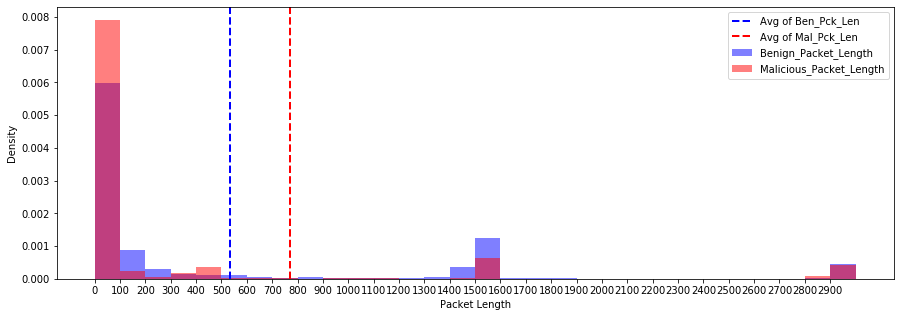

In [119]:
plt.figure(figsize = (15,5))

plt.hist(ben_pck_len, bins = 30, alpha = 0.5, range = (0,3000), density = True, color = 'b', label = 'Benign_Packet_Length')
plt.hist(mal_pck_len, bins = 30, alpha = 0.5, range = (0,3000), density = True, color = 'r', label = 'Malicious_Packet_Length')
plt.xticks(np.arange(0,3000,100))

plt.axvline(pd.DataFrame(ben_pck_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Pck_Len')
plt.axvline(pd.DataFrame(mal_pck_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Pck_Len')

plt.legend()

plt.xlabel('Packet Length')
plt.ylabel('Density')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
batch_size =32

train_set_idx = np.load('./ISCX2017/train_set_idx.npy')
train_random_sampler = torch.utils.data.SubsetRandomSampler(train_set_idx)
train_dataloader = DataLoader(flow_dataset, batch_size = batch_size, shuffle = False,  sampler = train_random_sampler)    

In [5]:
benign_flow_set = []
mal_flow_set = {i+1 : [] for i, flow in enumerate(attack_class_list)}

for i in tqdm(train_set_idx):
    flow, label = flow_dataset[i]

    if label==0:
        benign_flow_set.append(flow)
    else:
        mal_flow_set[label].append(flow)

100%|██████████| 140000/140000 [02:05<00:00, 1115.27it/s]


In [6]:
dataset = []

dataset += benign_flow_set[:5000]
for i in range(1,15):
    dataset += mal_flow_set[i][:5000]


In [9]:
dataset = np.array(dataset).reshape(44000,-1)

In [11]:
x = StandardScaler().fit_transform(dataset)

In [38]:
pca2D = PCA(n_components=2)
principalComponents2D = pca2D.fit_transform(x)

In [39]:
flow_label_2d = {}
prev_idx = 0

for i in range(0,15):
    if i ==2:
        flow_label_2d[2] = principalComponents2D[prev_idx:prev_idx + 4000]
        prev_idx += 4000
    
    else:
        flow_label_2d[i] = principalComponents2D[prev_idx:prev_idx + 5000]
        prev_idx += 5000

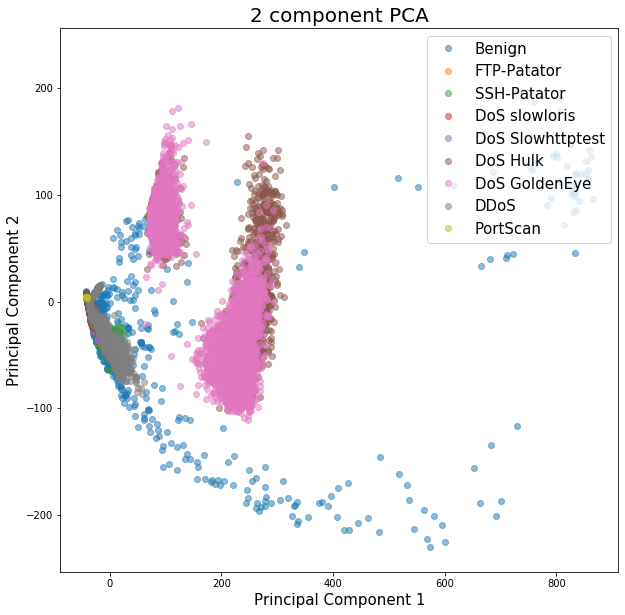

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize=20)

for i,label in zip(range(9),labels):
    ax.plot(flow_label_2d[i][:,0],flow_label_2d[i][:,1],marker='o',linestyle='', alpha = 0.5,label = label)

ax.legend(fontsize=15, loc='upper right')
plt.show()


In [12]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

In [22]:
flow_label = {}
prev_idx = 0

for i in range(0,15):
    if i ==2:
        flow_label[2] = principalComponents[prev_idx:prev_idx + 4000]
        prev_idx += 4000
    
    else:
        flow_label[i] = principalComponents[prev_idx:prev_idx + 5000]
        prev_idx += 5000

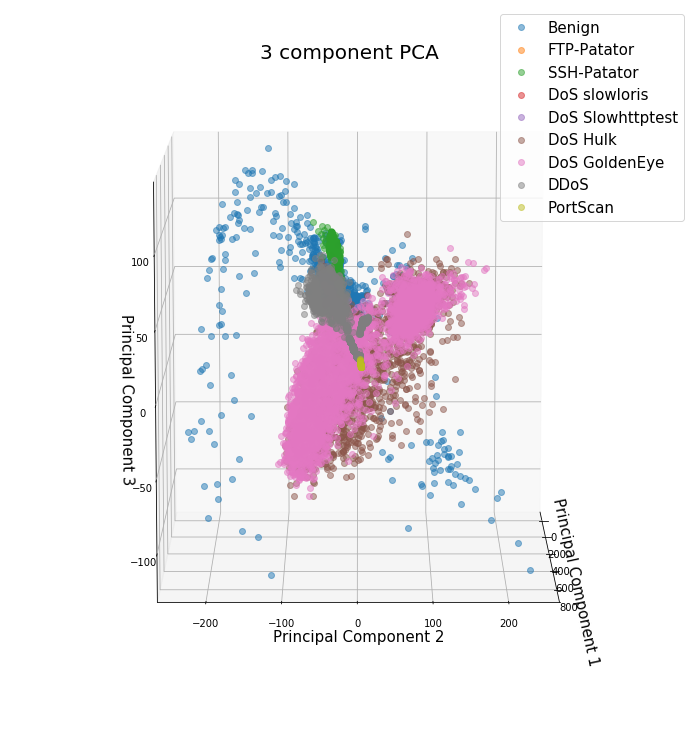

In [37]:
labels = ['Benign','FTP-Patator', 'SSH-Patator', 'DoS slowloris','DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'DDoS', 'PortScan']
fig = plt.figure( figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=10, azim= 0)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title('3 component PCA', fontsize=20)

for i,label in zip(range(9),labels):
    ax.plot(flow_label[i][:,0],flow_label[i][:,1], flow_label[i][:,2],marker='o',linestyle='', alpha = 0.5,label = label)

ax.legend(fontsize=15, loc='upper right')
plt.show()